##### References

** Specific example**
* https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch5/demo5_1.ipynb
* https://am207.github.io/2017/wiki/tumorlab.html
* http://blog.pmean.com/too-many-priors/

** Implementation hints**
* https://github.com/pymc-devs/pymc3/issues/699
* https://en.wikibooks.org/wiki/Probability/Transformation_of_Probability_Densities
* https://stackoverflow.com/questions/43710346/difference-between-betabinomial-and-beta-and-binomial/43734537#43734537

In [1]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from scipy import stats
import numpy as np
from matplotlib import  pyplot as plt
import theano.tensor as tt
import pymc3 as pm
from scipy import optimize
%matplotlib inline

In [2]:
RATS = 14
TUMORS = 4

In [3]:
n_tumors = [
    0, 0, 1, 2, 3, 4, 6, 0, 0, 1, 1, 2, 10, 5, 0, 0, 2, 5, 9, 4, 6, 
    0, 0, 2, 2, 10, 4, 6, 0, 1, 2, 5, 4, 4, 6, 0, 1, 2, 3, 4, 5, 6,
    0, 1, 2, 2, 4, 11, 16, 0, 1, 2, 7, 4, 12, 15, 0, 1, 2, 7, 4, 5,
    15,0,1,2,3,4,5,9]

n_rats = [
    20, 19, 18, 20, 20, 20, 23, 20, 18, 18, 10, 13, 48, 19, 20, 18,
    25, 49, 48, 19, 22, 20, 17, 24, 19, 50, 19, 20, 20, 20, 23, 46,
    20, 19, 20, 20, 20, 20, 27, 20, 22, 20, 20, 20, 20, 17, 20, 46,
    52, 19, 20, 20, 49, 20, 49, 47, 19, 19, 20, 47, 20, 20, 46, 19,
    19, 20, 20, 20, 20, 24]

data = pd.DataFrame({"tumors": n_tumors, "rats": n_rats})
data["rate"] = data.tumors / data.rats

In [4]:
data.head(5)

,rats,tumors,rate
0,20,0,0.000000
1,19,0,0.000000
2,18,1,0.055556
3,20,2,0.100000
4,20,3,0.150000


In [5]:
print("Number of Experiments (number of rats): ",len(n_rats))
print("Number of Experiments (number of tumors): ",len(n_tumors))

Number of Experiments (number of rats):  70
Number of Experiments (number of tumors):  70


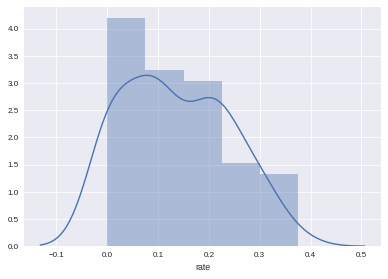

In [6]:
sns.set_context("paper")
sns.distplot(data.rate);

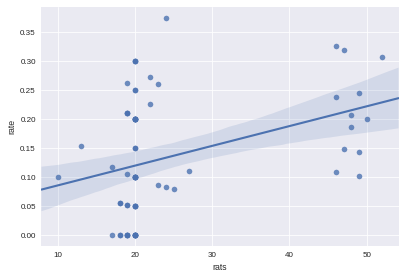

In [7]:
sns.regplot(data.rats, data.rate);

### Seperate model
* Let's completely throw away data from the other experiments.
* We only model the process with a Binomial and choosing an uninformative prior
* We will plot both, the analytical model and the pymc3 result for a special case
* Then we will plot the results for all experiments in order to get a feeling for the model

In [8]:
class AnalyticalBeta:
    
    def __init__(self, alpha, beta, tumors, rats):
        self.alpha = alpha
        self.beta = beta
        self.rats = rats
        self.tumors = tumors
        
    def predict(self, x):
        alpha = self.alpha + self.tumors 
        beta = self.beta + self.rats - self.tumors 
        return stats.beta(alpha, beta).pdf(x)
    
    def prior(self, x):
        return stats.beta(self.alpha, self.beta).pdf(x)
    
    
class SimulatedBeta:
    
    def __init__(self, alpha, beta, tumors, rats, samples=5000):
        self.alpha = alpha
        self.beta = beta
        self.rats = rats
        self.tumors = tumors
        self.samples = samples
        
    def predict(self):
        non_fully_bayes = pm.Model()
        with non_fully_bayes:
            # Prior
            p = pm.Beta('p', alpha=self.alpha, beta=self.beta)
            # Likelihood
            tumors = pm.Binomial('tumors', n=self.rats,  p=p, observed=self.tumors)
            trace = pm.sample(self.samples)
        return trace

* Result for one experiment with 10 RATS and 4 TUMORS

In [9]:
alpha = 1
beta = 1
grid = np.linspace(0,1,1000)
analytical = AnalyticalBeta(alpha, beta, TUMORS, RATS)
analytic_posterior = analytical.predict(grid)
prior = analytical.prior(grid)
mcmc = SimulatedBeta(alpha, beta, TUMORS, RATS).predict()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3.2302:   1%|          | 1943/200000 [00:00<00:20, 9573.71it/s]
Convergence archived at 2600
Interrupted at 2,600 [1%]: Average Loss = 3.3426
100%|██████████| 5500/5500 [00:03<00:00, 1467.95it/s]


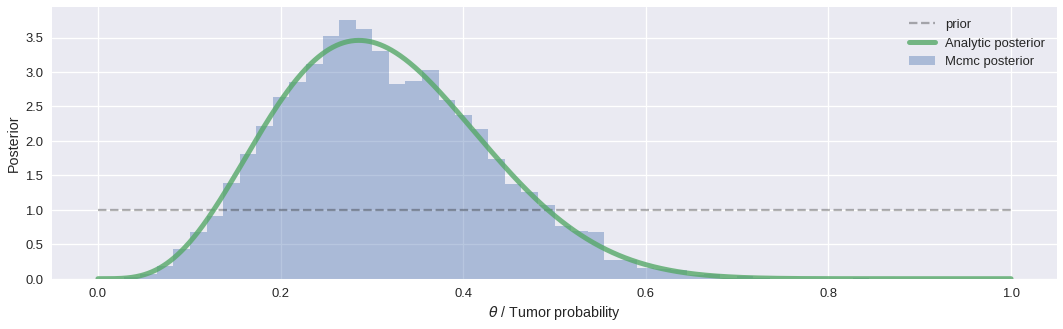

In [10]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(grid, prior, '--k', alpha = 0.3, label='prior')
ax.plot(grid, analytic_posterior, '-', alpha = 0.8, color='#55a868', linewidth=5, label='Analytic posterior')
sns.distplot(mcmc['p'], kde=False, norm_hist=True, ax=ax, label='Mcmc posterior');
ax.set_xlabel(r"$\theta$ / Tumor probability")
ax.set_ylabel("Posterior")
plt.legend();

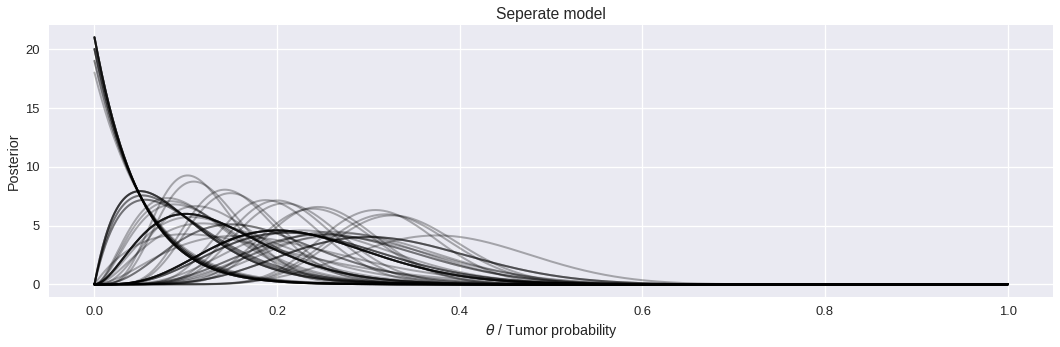

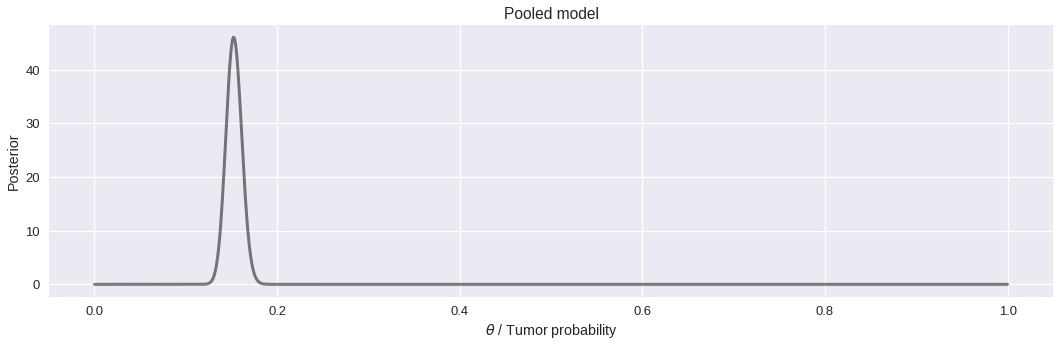

In [11]:
def plot_seperate_model(data, grid, alpha=1, beta=1, title='Seperate model'):
    fig, ax = plt.subplots(figsize=(18,5))
    for exp in range(data.shape[0]): 
        tumors = data.iloc[exp, 1]
        rats = data.iloc[exp, 0]
        posterior = AnalyticalBeta(alpha, beta, tumors, rats).predict(grid)
        ax.plot(grid, posterior, '-', alpha = 0.3, color='k', linewidth=2)
    ax.set_xlabel(r"$\theta$ / Tumor probability")
    ax.set_ylabel("Posterior")
    ax.set_title(title);

def plot_pooled_model(data, grid, alpha=1, beta=1, title='Pooled model'):
    fig, ax = plt.subplots(figsize=(18,5))
    pooled_tumors = data.tumors.sum()
    pooled_rats = data.rats.sum()
    posterior = AnalyticalBeta(alpha, beta, pooled_tumors, pooled_rats).predict(grid)
    ax.plot(grid, posterior, '-', alpha = 0.5, color='k', linewidth=3)
    ax.set_xlabel(r"$\theta$ / Tumor probability")
    ax.set_ylabel("Posterior")
    ax.set_title(title);
    
plot_seperate_model(data, grid)
plot_pooled_model(data, grid)

### Non-fully bayesian approach
* Make Beta-Binomial Model
* Prior Parameters in the Beta Distribution taken from sample behaviour
* A full bayesian behaviour would be to also infer the pdf alpha and beta
* So, this is essentially the very same but with a different prior distrubution, which is derived from the sample instead of a non-informative prior

In [12]:
def get_beta_parameters_from_sample(mean, variance):
    alpha_plus_beta = mean * (1-mean) / variance - 1
    alpha = alpha_plus_beta *  mean
    beta = alpha_plus_beta * (1 - mean)
    return alpha, beta

In [13]:
grid = np.linspace(0,1,100)
alpha, beta = get_beta_parameters_from_sample(data.rate.mean(), data.rate.var())
print(alpha, beta)
grid = np.linspace(0,1,100)
analytical = AnalyticalBeta(alpha, beta, TUMORS, RATS)
analytic_posterior = analytical.predict(grid)
prior = analytical.prior(grid)
mcmc = SimulatedBeta(alpha, beta, TUMORS, RATS).predict()
print(alpha, beta)

1.35614939103 8.61505789132


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2.9702:   0%|          | 810/200000 [00:00<00:24, 8097.71it/s]
Convergence archived at 1600
Interrupted at 1,600 [0%]: Average Loss = 2.8879
100%|██████████| 5500/5500 [00:03<00:00, 1537.67it/s]

1.35614939103 8.61505789132


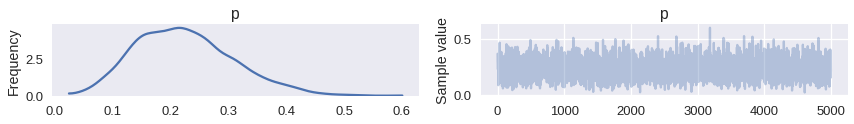

In [14]:
pm.traceplot(mcmc);

In [15]:
print("MCMC posterior mean: ", mcmc['p'].mean())
print("MCMC posterior std: ", mcmc['p'].std())

MCMC posterior mean:  0.224868504269
MCMC posterior std:  0.0835468839978


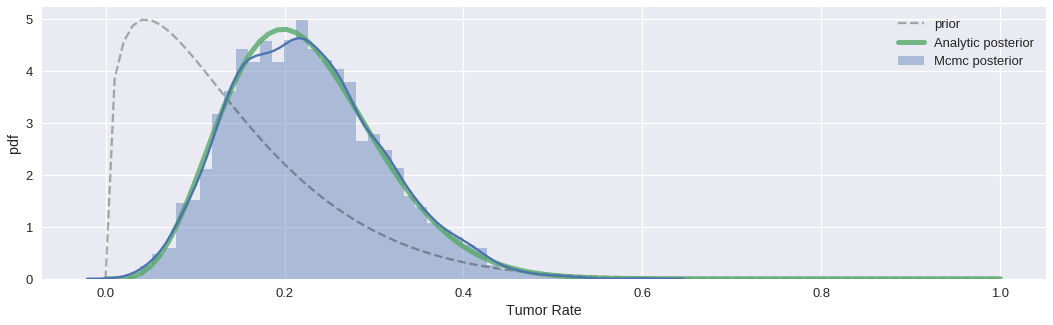

In [16]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(grid, prior, '--k', alpha = 0.3, label='prior')
ax.plot(grid, analytic_posterior, '-', alpha = 0.8, color='#55a868', linewidth=5, label='Analytic posterior')
sns.distplot(mcmc['p'], kde=True, norm_hist=True, ax=ax, label='Mcmc posterior');
ax.set_xlabel('Tumor Rate')
ax.set_ylabel('pdf')
plt.legend();

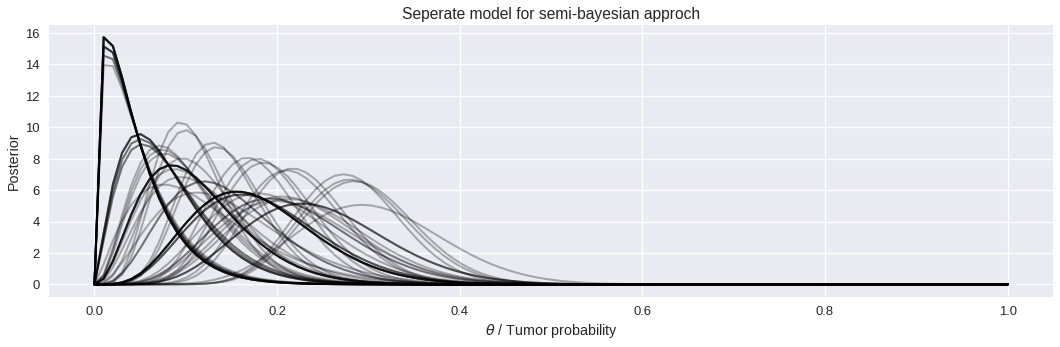

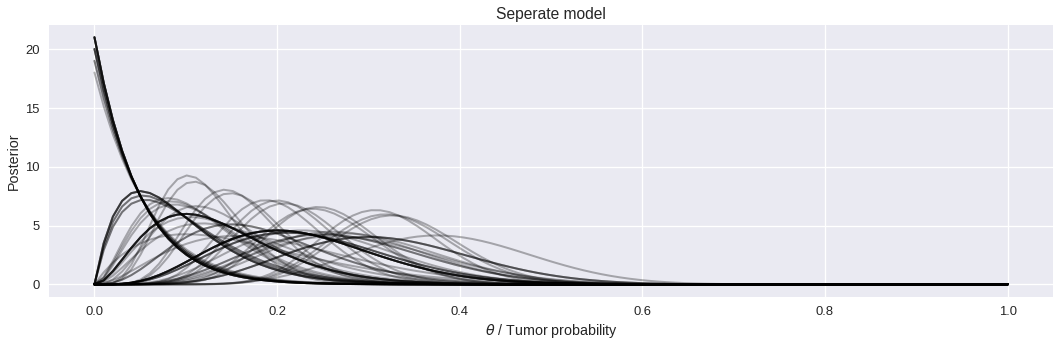

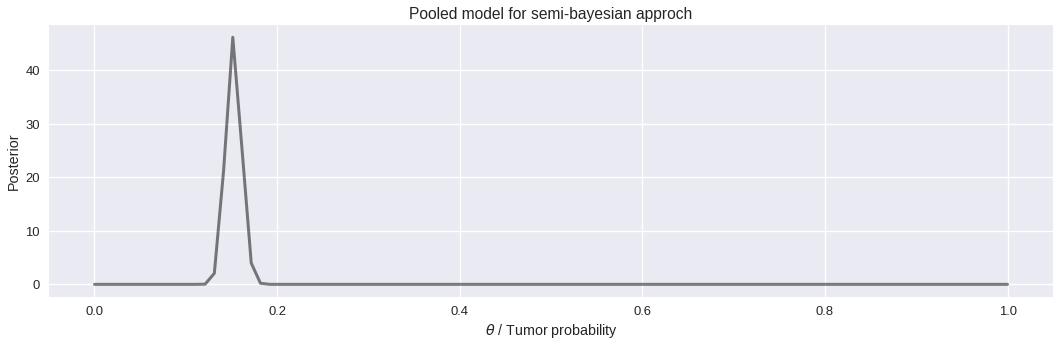

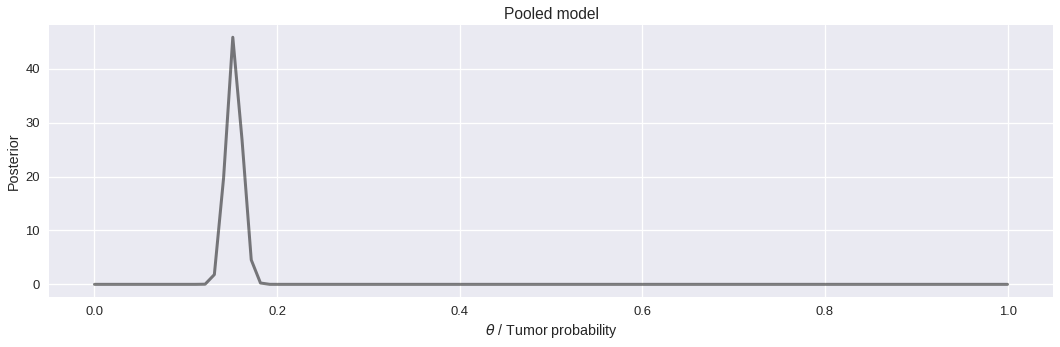

In [17]:
plot_seperate_model(data, grid, alpha=alpha, beta=beta, title="Seperate model for semi-bayesian approch")
plot_seperate_model(data, grid)

plot_pooled_model(data, grid, alpha=alpha, beta=beta, title='Pooled model for semi-bayesian approch')
plot_pooled_model(data, grid)

### Hierarchical model

**Setup the model:**
* The data for the experiment $i=1 \dots I, I=71$ are assumed to follow independent binomial distributions:
 $y_i \sim Bin(n_j, \theta_j)$
  $y_i$ the number of tumors (unknown), $n_j$  the number of rats (known), and the $\theta_j$ the tumor rates or probabilities (unknown).
* The parameters $\theta_j$ are assumed to be independent samples from the beta distribution, $\theta_j \sim Beta(\alpha, \beta)$


**Note:**
In the model above also assumed a beta distribution. However, we took a point estimate for $\alpha$ and $\beta$, which was obtained from the overall sample behaviour. So, the difference is that we would like to infer a distribution over $\alpha$ and $\beta$. As a consequence we need to setup a prior distribution over those parameters, whereas in the previous part we had a prior distribution over $\theta_i$ (given by the Beta distrubtion with the point estimates for $\alpha, \beta$)

Before we write down the explicit form of the pdf, we quickly scetch the corresponding directed acyclic graph (DAG) of this model:

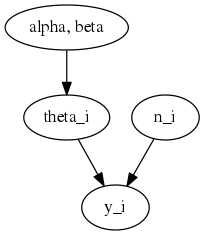

In [18]:
import networkx as nx
from nxpd import draw
G = nx.DiGraph()
G.graph['dpi'] = 90
G.add_nodes_from(["n_i", "theta_i", "y_i", "alpha, beta"])
G.add_edges_from([("n_i","y_i"), ("alpha, beta","theta_i"), ("theta_i", "y_i")])
draw(G, show='ipynb')

### Semi-Analytical approach

From this DAG, we obtain the joint pdf
$$p(\alpha, \beta, n, y, \theta) = p(\alpha, \beta) ~ \Pi_{i=1}^{I} ~  p(y_i ~|~ n_i, \theta_i) ~ p(n_i) ~ p(\theta_i ~ |~ \alpha, \beta)$$

where we used the shorthand notation on the left hand side e.g., $n=n_1,\dots n_I$,  $y=y_1,\dots y_I$, and $\theta= \theta_1,\dots \theta_I$

** Computing the (joint) posterior**

Before we plug in the actual models for the probability distributions, we may go ahead to compute the postierior. Precisely we are interested in the quantity
$$p(\alpha, \beta, \theta ~|~ n, y) = \frac{p(\alpha, \beta, \theta, n, y)}{p(n,y)} = \frac{p(\alpha, \beta, \theta, n, y)}{p(y~|~n)p(n)} = \frac{(\alpha, \beta, \theta, y ~|~ n)}{p(y~|~n)}$$

The last expression allows for some simplification (more elegantly: analyse the DAG from above)
$$p(\alpha, \beta, \theta, y ~ | ~ n) = p(\alpha, \beta) ~ \Pi_{i=1}^{I} ~  p(y_i ~|~ n_i, \theta_i) ~  p(\theta_i ~|~ \alpha, \beta)$$. We have just jused $p(n) = \int p(\alpha, \beta, n, y, \theta) ~ d \alpha ~ d \beta ~ d  \theta ~ d y = \Pi_i p(n_i)$. 

Plugging this expression into the formular for the postierior,

$$p(\alpha, \beta, \theta ~|~ n, y) = \frac{ p(\alpha, \beta) ~ \Pi_{i=1}^{I} ~  p(y_i ~|~ n_i, \theta_i) ~  p(\theta_i ~|~ \alpha, \beta)}{p(y ~|~n)} $$

Note that the demoniator $p(y ~|~n)$ is 'just' a normalization constant for the postierior $p(\alpha, \beta, \theta ~|~ n, y)$ because it does not explicitly depend on $(\alpha, \beta, \theta)$. So we can use the usual sloppy notation

$$p(\alpha, \beta, \theta ~|~ n, y) \sim  p(\alpha, \beta) ~ \Pi_{i=1}^{I} ~  p(y_i ~|~ n_i, \theta_i) ~  p(\theta_i ~|~ \alpha, \beta)$$.

**A word of warning**

So, this is not a pdf since it is not normalized. However scale invariant quantities such as the mode may be derived from this. In general the normalization needs to be considered - after all that's why we will be using Marcov Chain Monte Carlo simulations. However, we will start off with this unnormalized expression in order to get a feeling for the expected results.

**Specifying the pdfs**

Eventually we are ready to specify the pdfs used for the posterior:
* $p(\theta_i ~|~ \alpha, \beta) = Beta(\theta_i ~ | ~ \alpha, \beta)$
* $p(y_i ~|~ n_i, \theta_i) = Bin(y_i ~ | ~ n_i, \theta_i)$
* $p(\alpha, \beta) \sim (\alpha + \beta)^{-5/2} $



$$p(\alpha, \beta, \theta ~|~ n, y) \sim p(\alpha, \beta) \Pi_{i=1}^I \frac{\Gamma(\alpha + \beta )}{\Gamma(\alpha)\Gamma(\beta)} \theta_i ^ {\alpha + y_i -1}(1-\theta_i)^{\beta + n_i - y_i -1}$$

** Marginal posterior**

That's it. Up to the normalization function we are done. For a further analysis it will be illustrative 
to compute the marginal posterior distribution:
* $p(\alpha, \beta  ~|~  n, y)$

To this end, we need to integrate the posterior over the $\theta_i$.
We use the fact, that the Beta distribution is conjugate to the Binomial, i.e., 
$Beta(\theta_i ~ | ~ \alpha, \beta) Bin(y_i ~ | ~ n_i, \theta_i) = Beta(\theta_i ~ | ~ \alpha + y_i, \beta + n_i - y_i)$. So the terms dependent on the $\theta_i$ are essentially the Beta distribution - up to the normalization constant. And thus, keeping track of those constants the integral evaluates to one for each $i$.
We therefore get:

$$p(\alpha, \beta  ~|~  n, y) \sim p(\alpha, \beta)\Pi_{i=1}^I \frac{\Gamma(\alpha + \beta )}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + y_i) \Gamma(\beta + n_i - y_i)}{\Gamma(\alpha + \beta + n_i)}$$ 

** Conditional posterior**
Note that the marginal posterior w.r.t. the $\theta_i$ is much harder to get. However, what we would expect is that the conditional posterior distribution, 
* $p (\theta ~|~ \alpha, \beta,  n, y)$ 

is just the product of Beta distributions. Because, once $(\alpha, \beta)$ are given the $\theta$ should just be of the normal Beta-Binomial form. We quickly check this,
$$p (\theta ~|~ \alpha, \beta, n, y) = \frac{p(\alpha, \beta, \theta ~|~ n, y)}{p(\alpha, \beta | n, y)} = \Pi_{i=1}^I Beta(\theta_i ~ | ~ \alpha + y_i, \beta + n_i - y_i) $$ 
Because by construction $p(\alpha, \beta | n, y) = p(\alpha, \beta) $, which canels the term $p(\alpha, \beta)$  from the joint posterior, and the constants cancel because the Beta distribution is a proper pdf. This also implies that we have a strict equal sign.

### Analysis of prior and marginal posterior distribution of $(\alpha, \beta)$
Now we are ready to analyze the model. We will first focus on the analytic part.
In particular we will
1. Compare the prior $p(\alpha, \beta)$ with its posterior $p(\alpha, \beta ~|~ n, y)$
2. Do the same thing on transformed variables in order to make contact with Gelman

In [19]:
from functools import partial
from scipy.special import gammaln

def logprior(x):
    return - 5/2 * np.log(x[0] + x[1])

def log_marginal_posterior_generator(x, n, y):
    log_prior = logprior(x)
    log_factor = gammaln(x[0] + x[1]) - gammaln(x[0]) - gammaln(x[1])
    log_learning = gammaln(x[0] + y) + gammaln(x[1] + n - y)  - gammaln(x[0] + x[1] + n)
    return log_prior + len(n) * log_factor + log_learning.sum()    

    
log_marginal_posterior_analytical = partial(log_marginal_posterior_generator, 
                                 n=data.rats.values, 
                                 y=data.tumors.values)

In [20]:
def pdf_on_grid(alpha_grid, beta_grid, log_pdf):
    lpdf = function_on_grid(alpha_grid, beta_grid, log_pdf)
    lpdf = lpdf - lpdf.max()
    return np.exp(lpdf)

def function_on_grid(xgrid, ygrid, function:callable):
    xshape = len(xgrid)
    yshape = len(ygrid)
    grid_function = np.zeros((xshape, yshape))
    #print("The grid function has shape {}".format(np.shape(grid_function)))
    for xid in range(xshape):
        for yid in range(yshape):
            point = [xgrid[xid], ygrid[yid]]
            #print("function value at point {p1}, {p2} is {f}".format(p1=xgrid[xid], p2=ygrid[yid], f=function(point)))
            grid_function[xid, yid] = function(point)
            
    return grid_function

In [21]:
A = np.linspace(0.5, 3, 300)
B = np.linspace(3, 33, 300)
marginal_pdf = pdf_on_grid(A, B, log_marginal_posterior_analytical)
prior_pdf = pdf_on_grid(A, B, logprior)

#### Posterior marginal on tranformed space

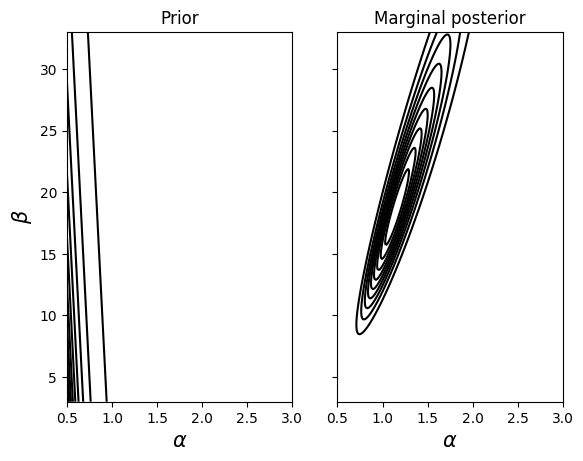

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.contour(prior_pdf, 10, colors='k', extent=(A[0], A[-1], B[0], B[-1]))
ax2.contour(marginal_pdf, 10, colors='k', extent=(A[0], A[-1], B[0], B[-1]))
ax1.set_xlabel(r'$\alpha$', fontsize=15)
ax1.set_ylabel(r'$\beta$',  fontsize=15)
ax2.set_xlabel(r'$\alpha$', fontsize=15)
ax1.set_title('Prior')
ax2.set_title('Marginal posterior');

### Excursion to variable transformations

#### Formal setup:
Let $$Y=g(X)$$ 
be a variable transformation on random variables and $p_X(x)$ the pdf on $X$. Then on $Y$ the pdf reads
$$p_Y(y) = p_X(g^{-1}(y)) J_{g^{-1}(y)} $$
where $J_{g^{-1}(y)} $ is the Jacobian of the inverse function $g$.

Let's intruduce some wording (the educated differential geometrists starts feeling cosy) and call the map $g$ **pushforward** and $g^{-1}$ **pullback**.

#### Specific transformation:
The basic idea behind Gelman's transformation is to consider the transformation function (pushforward)
$$ f:  \mathbb R_+ \times \mathbb R_+  \rightarrow \mathbb R \times \mathbb R  \\
(\alpha, \beta)  \mapsto  (\log(\frac{\alpha}{\beta}), \log(\alpha+\beta))
$$

**Pullback**

In order to transform our pdf to $f(\alpha, \beta) = (\alpha^\prime, \beta^\prime)$ we need to compute the inverse function $f^{-1}$ and it's Jacobian Determinant. Setting
$$\alpha^\prime = \log(\frac{\alpha}{\beta})\\ 
\beta^\prime = \log(\alpha + \beta)$$
and solving for $(\alpha, \beta)$ gives
$$f^{⁻1}: (\alpha^\prime, \beta^\prime) \mapsto  (\frac{ e^{\beta^\prime}}{1 + e^{-\alpha^\prime}}, \frac{ e^{\beta^\prime}}{1 + e^{\alpha^\prime}})$$
And the Jacobian Determinant is therefore
$$J_{f^{-1}}(\alpha^\prime, \beta^\prime) =\frac{e^{2\beta^\prime}}{(2 + e^{-\alpha^\prime} + e^{\alpha^\prime})}$$

That's all we need to go to the transformed space

In [23]:
def transform_pdf_generator(x_prime, pdf, pullback, jacobian):
    """Generates a transformed pdf"""
    x = pullback(x_prime)
    return pdf(x) * jacobian(x)

def transform_log_pdf_generator(x_prime, log_pdf, pullback, jacobian):
    """Generates a transformed log-pdf"""
    x = pullback(x_prime)
    return log_pdf(x) + np.log(jacobian(x_prime))
    

def pullback(x_prime):
    """Specific pullback traf  (inverse map)"""
    alpha = np.exp(x_prime[1]) / (1+  np.exp(-x_prime[0]))
    beta = np.exp(x_prime[1]) - alpha
    return np.array([alpha, beta])


def jacobian_pullback(x_prime):
    """Specific pullback jacobian (from inverse map)"""
    denominator = 2 + np.exp(-x_prime[0]) + np.exp(x_prime[0])
    return np.exp(2*x_prime[1]) / denominator
    #return x[0] * x[1]

    
def pushforward(x):
    """Specific pushforward traf (map)"""
    alpha_prime = np.log(x[0]/x[1])
    beta_prime = np.log(x[0] + x[1])
    return np.array([alpha_prime, beta_prime])


def jacobian_pushforward(x):
    """Specific pushforward jacobian (map)"""
    return  1 / (x[0] * x[1])


transformed_log_marginal = partial(transform_log_pdf_generator, 
                                   log_pdf=log_marginal_posterior_analytical, 
                                   pullback=pullback, 
                                   jacobian=jacobian_pullback)


transformed_log_prior = partial(transform_log_pdf_generator,
                                log_pdf = logprior, 
                                pullback = pullback,
                                jacobian = jacobian_pullback)

back_transformed_log_marginal = partial(transform_log_pdf_generator,
                           log_pdf = transformed_log_marginal,
                           pullback = pushforward,
                           jacobian = jacobian_pushforward)

#### Posterior marginal on tranformed space

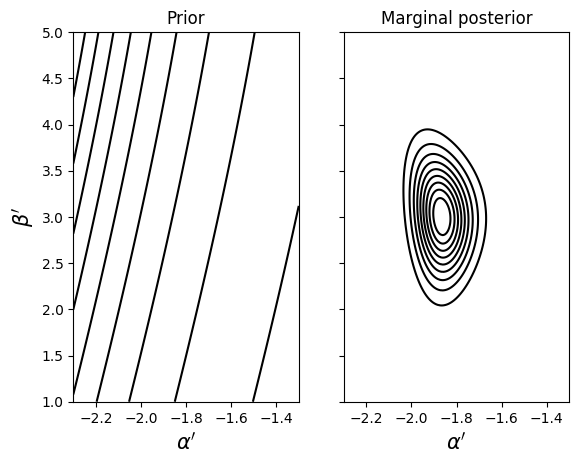

In [24]:
A = np.linspace(-2.3, -1.3, 200)
B = np.linspace(1, 5, 200)
marginal_pdf = pdf_on_grid(A, B, transformed_log_marginal)
prior_pdf = pdf_on_grid(A, B, transformed_log_prior)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.contour(prior_pdf, 10, colors='k', extent=(A[0], A[-1], B[0], B[-1]))
ax2.contour(marginal_pdf, 10, colors='k', extent=(A[0], A[-1], B[0], B[-1]))
ax1.set_xlabel(r'$\alpha^\prime$', fontsize=15)
ax1.set_ylabel(r'$\beta^\prime$',  fontsize=15)
ax2.set_xlabel(r'$\alpha^\prime$', fontsize=15)
ax1.set_title('Prior')
ax2.set_title('Marginal posterior');

* Let's find the maximum of this function in direct space. 
* Use as starting point the ensemble guess from above
* also print the maximum in the transformed space (see below)
* Note that the optimization is quite unstable!

In [25]:
start = list(get_beta_parameters_from_sample(data.rate.mean(), data.rate.var()))
print(start)
objective_function = lambda x: -log_marginal_posterior_analytical(x)
res = optimize.fmin_powell(objective_function, start)
print('Maximum in untransformed space: ', res)
print('Maximum in transformed space: ', pushforward(res))

[1.3561493910319327, 8.6150578913207863]
Optimization terminated successfully.
         Current function value: 727.683346
         Iterations: 3
         Function evaluations: 82
Maximum in untransformed space:  [  1.73846449  10.22945755]
Maximum in transformed space:  [-1.7722693   2.48222991]


* And now let's directly find the optimum in the transformed space

In [26]:
objective_function = lambda x: - transformed_log_marginal(x)
res = optimize.fmin_powell(objective_function, pushforward(start))
print('Maximum in untransformed space: ', pullback(res))
print('Maximum in transformed space: ', res)

Optimization terminated successfully.
         Current function value: 724.493517
         Iterations: 2
         Function evaluations: 46
Maximum in untransformed space:  [  2.19357604  13.24215147]
Maximum in transformed space:  [-1.79787193  2.73668479]


#####  consistency checks:
* does the back transformed ~ log_pdf give the same result as the original?
* does the back transformed log_pdf give the same maximum?

In [27]:
# check pushback and pullforward working
point = np.array([.5,.5])
"""
print(pushforward(pullback(point)))
print(pullback(pushforward(point)))
print(np.log(jacobian_pushforward(point)) + np.log(jacobian_pullback(point)))
print(jacobian_pushforward(point) * jacobian_pullback(point))
"""
print('original', log_marginal_posterior_analytical(point))
print('transformed on pushed point', transformed_log_marginal(pushforward(point)))
print('contribution of jacobian', np.log(jacobian_pullback(pushforward(point))))
print('back transformed', back_transformed_log_marginal(point))

original -781.327401039
transformed on pushed point -782.7136954
contribution of jacobian -1.38629436112
back transformed -781.327401039


In [28]:
objective_function = lambda x: -back_transformed_log_marginal(x)
res = optimize.fmin_powell(objective_function, start)
print('Maximum in untransformed space: ', res)
print('Maximum in transformed space: ', pushforward(res))

Optimization terminated successfully.
         Current function value: 727.683346
         Iterations: 3
         Function evaluations: 82
Maximum in untransformed space:  [  1.73846449  10.22945755]
Maximum in transformed space:  [-1.7722693   2.48222991]


yes it does! all fine so far!
But, wait a bit:

##### Remarks
* Apperently the the transformed and the original log pdf gives different numrical results
* This is to be expected!
* The reason is that that we eventually transform pdfs, which also consider the jacobian in addition to pointwise transformations (pullback/pushforward).
* On the other, if we wanted to translate pointwise results (mean, mode etc) we were using the plain transformation (pullback, pushforward). So the results deviate by expressions that are related to the jacobian.


* **In principles there are two  possibilities to treat this problem:**
1. **Possibility 1:**
* Compute the posterior pdf in a convenient, that is transformed space. 
* Then transform back the result into the original parametrization. 
* Compute the estimates in the original space. 
* Note that in the context of mcmc where we compute the histograms this probably corresponds to point back - transformations

2. **Possibility 2**
* Don't use the pointwise back transformation, but rather a more sophisticated one that also takes into account the jacobian
* I guess this is solved in the literature

### 'Manual' sampling of the joint posterior distribution
**Reference:** https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch5/demo5_1.ipynb

**Untransformed space**
In order to make predictions, we would like to draw, say 1000 samples from the joint posterior distribution $p(\alpha, \beta, \theta_1, \dots \theta_n)$. Eventually we want the posterior distributions in the $\theta_i$' and compute median, and credibility intervals.  To this end, we
1. Simulate 1000 draws of $(\alpha, \beta)$  from their marginal posterior distribution
2. For each draw of  $(\alpha, \beta)$, simulate $\theta_i, i=1 \dots I$ from $Beta(\theta_i ~ | ~ \alpha + y_i, \beta + n_i - y_i)$ (see theory section)
3. For each ensuing distribution of $\theta_i$ compute median and credibility interval

In [29]:
def sample_alpha_beta_posterior(alpha_grid, beta_grid, log_pdf, nsamp, add_jitter=True):
    p = pdf_on_grid(alpha_grid, beta_grid, log_pdf)
    flat_samp_indices = np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum())
    samp_indices = np.unravel_index(flat_samp_indices, p.shape)
    samp_alpha = alpha_grid[samp_indices[1]]
    samp_beta = beta_grid[samp_indices[0]]
    if add_jitter:
        samp_alpha += (np.random.rand(nsamp) - 0.5) * (alpha_grid[1]-alpha_grid[0])
        samp_beta += (np.random.rand(nsamp) - 0.5) * (beta_grid[1]-beta_grid[0])
    return pd.DataFrame({'alpha':samp_alpha, 'beta':samp_beta})


def sample_theta_posterior(a_b_sample: pd.DataFrame, n_tumors, n_rats, grid):
    alpha = a_b_sample.alpha + n_tumors
    beta = a_b_sample.beta + n_rats - n_tumors
    return np.mean(stats.beta.pdf(grid[:], alpha[:, None], beta[:, None]), axis=0)


def sample_theta_posteriors(a_b_sample: pd.DataFrame, experiments: pd.DataFrame, grid): 
    result = pd.DataFrame()
    for exp in experiments.index:
        n_tumors = experiments.iloc[exp,1]
        n_rats = experiments.iloc[exp,0]
        prediction = sample_theta_posterior(a_b_sample, n_tumors, n_rats, grid)
        prediction_df = pd.DataFrame({exp: prediction})
        result = pd.concat([result, prediction_df], axis=1)
    return result
    
    
    
def plot_hc_model(predictions, grid, title='Hierarchical model'):
    fig, ax = plt.subplots(figsize=(18,5))
    exps = predictions.shape[1]
    for exp in range(exps):
        ax.plot(grid, predictions.iloc[:, exp], '-', alpha = 0.3, color='k', linewidth=2)
    ax.set_xlabel(r"$\theta$ / Tumor probability")
    ax.set_ylabel("Posterior")
    ax.set_title(title);

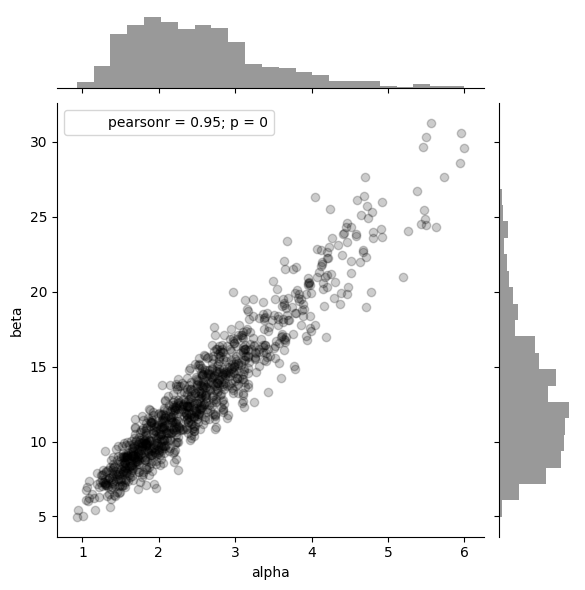

In [30]:
A = np.linspace(0.5, 6, 300)
B = np.linspace(3, 33, 300)
grid = np.linspace(0, 1, 250)
samples = sample_alpha_beta_posterior(A, B, log_marginal_posterior_analytical, 1000)
sns.jointplot(x='alpha', y='beta',  data=samples, color='k', alpha=.2);

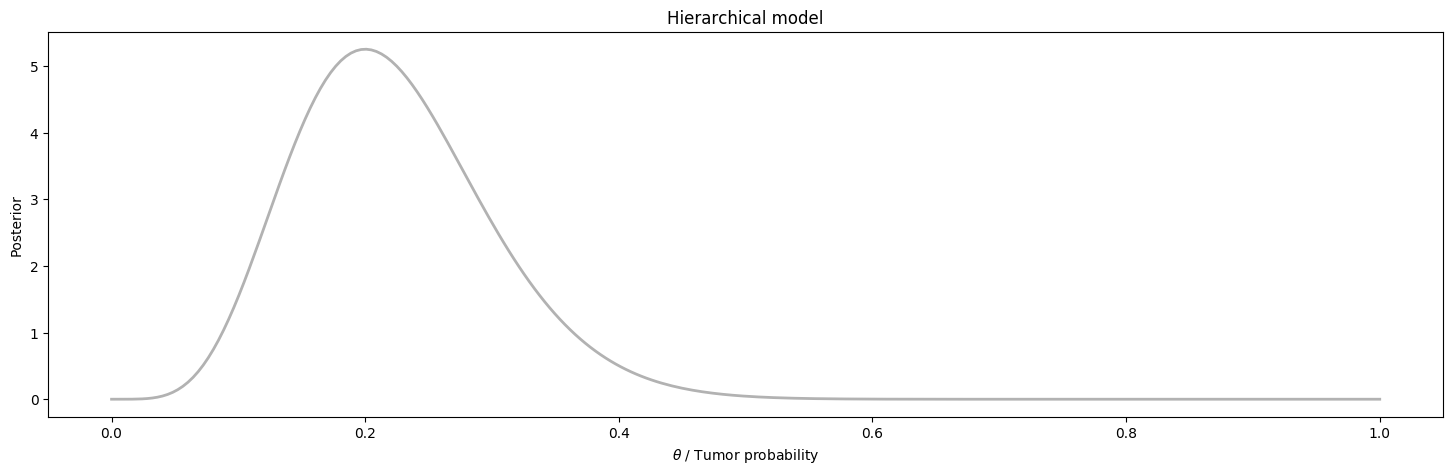

In [31]:
prediction = sample_theta_posterior(samples, TUMORS, RATS, grid)
plot_hc_model(pd.DataFrame(prediction), grid)

In [32]:
predictions = sample_theta_posteriors(samples, data, grid)

** Plot and Compare models ** 

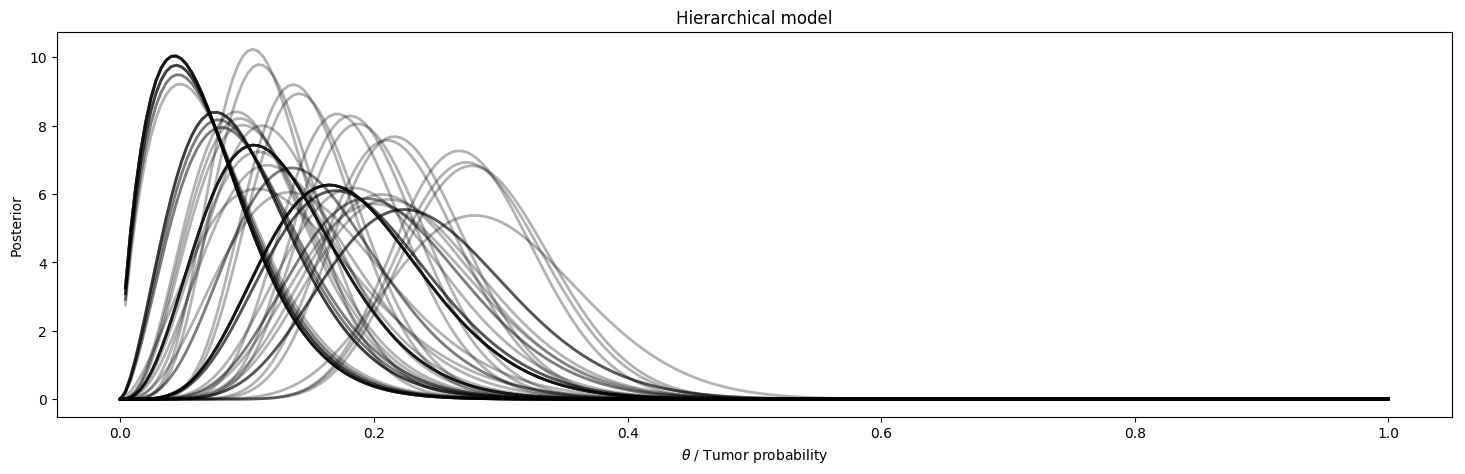

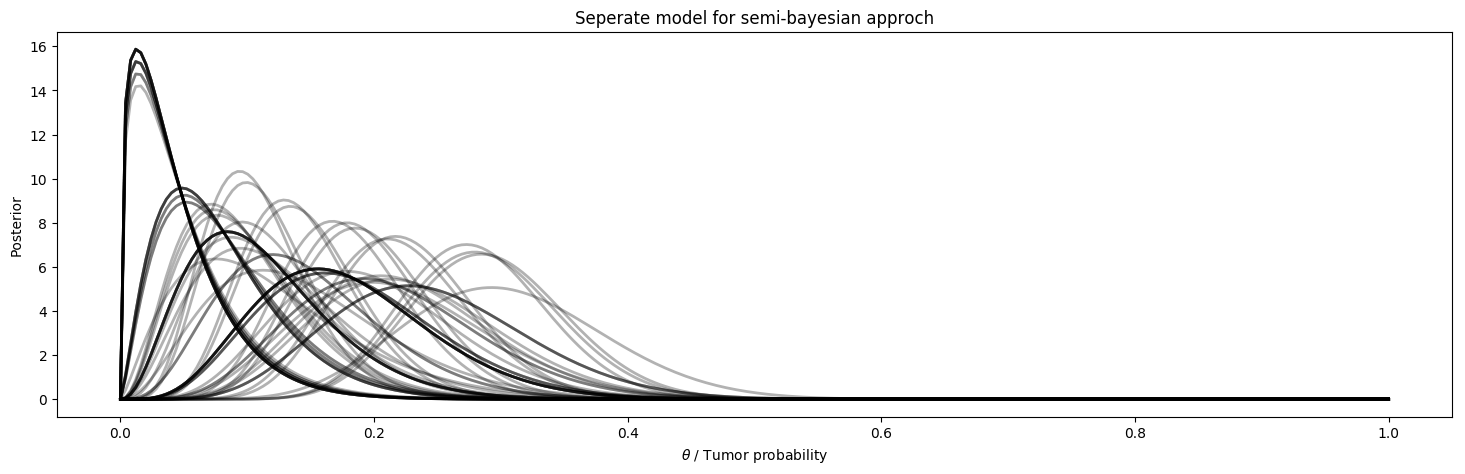

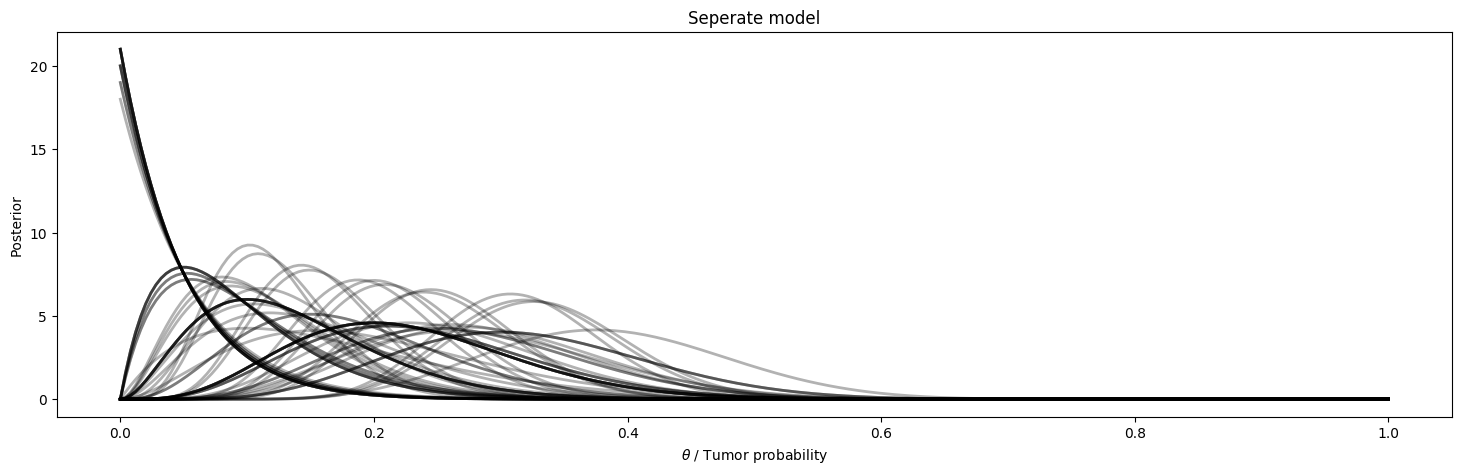

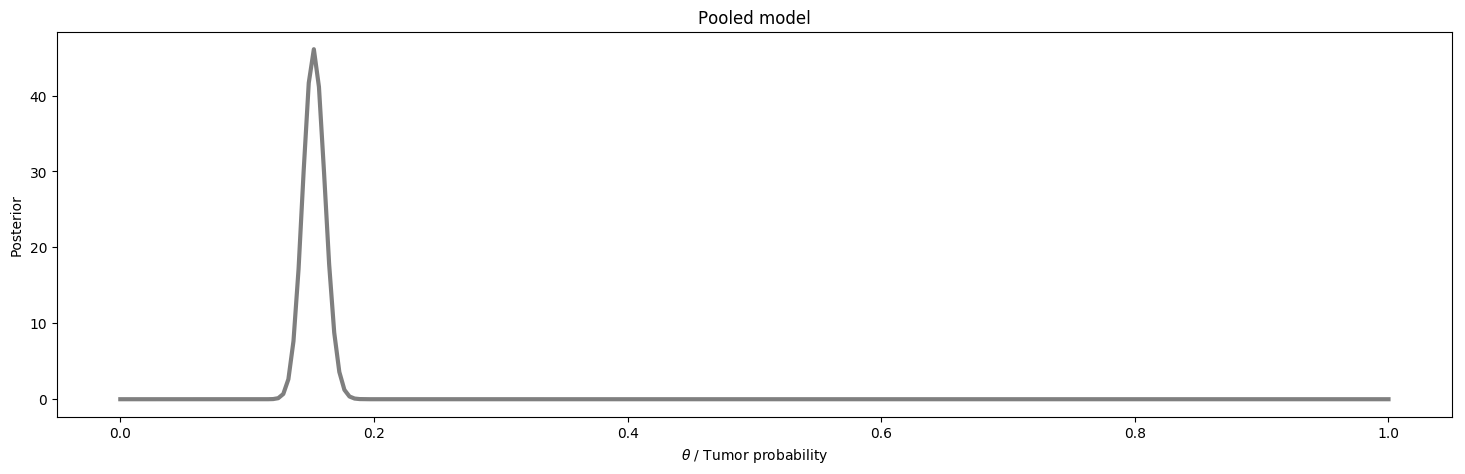

In [33]:
plot_hc_model(predictions, grid)
plot_seperate_model(data, grid, alpha=alpha, beta=beta, title="Seperate model for semi-bayesian approch")
plot_seperate_model(data, grid)
plot_pooled_model(data, grid)

# Markov-Chain  Monte-Carlo sampling
### Uniform priors
* before we actually do the model with our custom prior, we look at the uniform prior in the first place.
* according to this post https://stackoverflow.com/questions/43710346/difference-between-betabinomial-and-beta-and-binomial/43734537#43734537 we need to be numerically careful about how to incorporate the Beta-Binomial model
* **First let's use the pymc implemented Beta-Binomial pdf**


In [34]:
hierarchical = pm.Model()

with hierarchical:
    alpha = pm.Uniform('alpha', 0, 50)
    beta = pm.Uniform('beta', 0, 50)
    tumors = pm.BetaBinomial('tumors', alpha=alpha, beta=beta, n=data.rats, observed=data.tumors) 
    trace = pm.sample(2000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 164.84:   5%|▍         | 9897/200000 [00:01<00:31, 6091.26it/s] 
Convergence archived at 10200
Interrupted at 10,200 [5%]: Average Loss = 238.68
100%|██████████| 3000/3000 [00:05<00:00, 531.46it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa70c28fc18>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fa70cf0bb38>]], dtype=object)

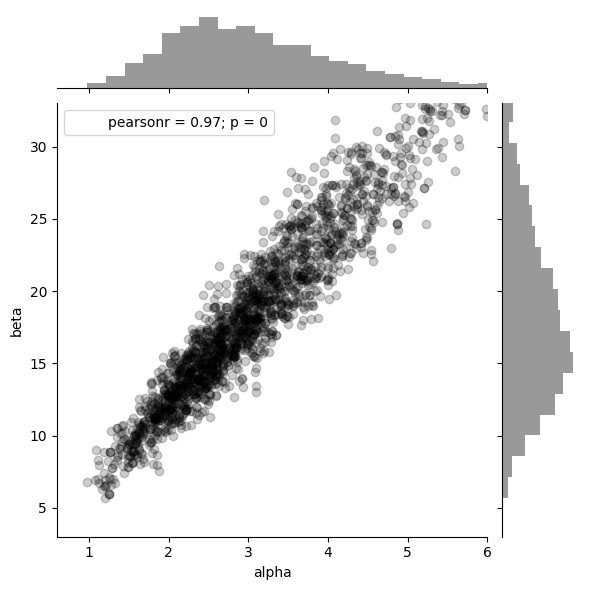

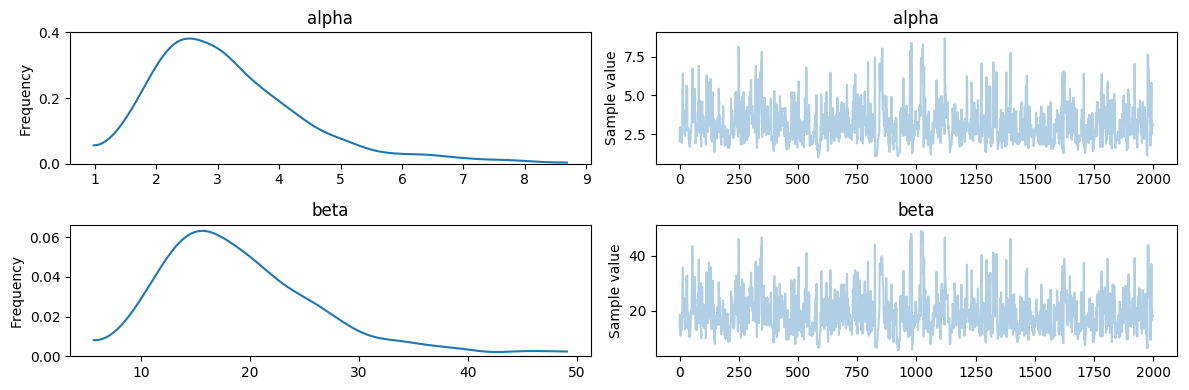

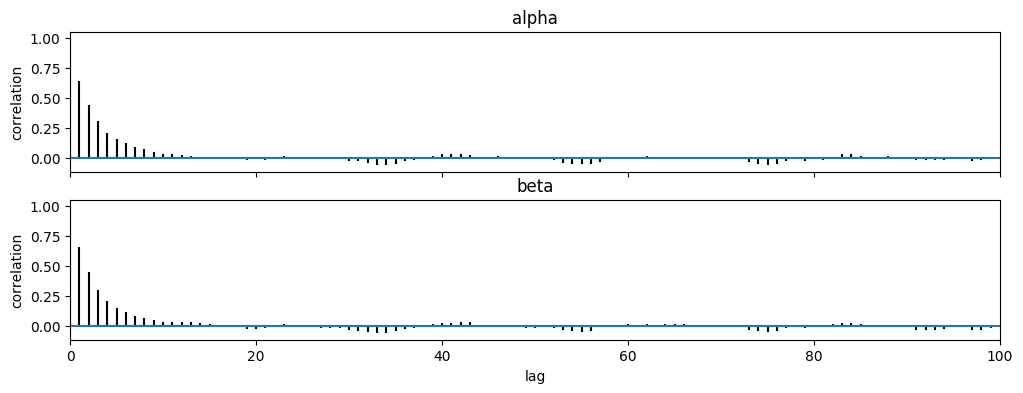

In [35]:
df = pm.trace_to_dataframe(trace)
sns.jointplot(x='alpha', 
              y='beta', 
              data=df[['alpha', 'beta']],
              xlim=(.6, 6),
              ylim=(3, 33), 
              #kind='kde'
              color='k',
              alpha=.2
             )
pm.traceplot(trace)
pm.plots.autocorrplot(trace)

**Of course we could do the Beta-Binomial model by hand**
* This eventually yields the very same result
* However, care must be taken in order to draw for each experiment(sample) from the Hyperdistribution
* This is achieved by employing the shape keyword in the Beta Distribution

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 176.39:   7%|▋         | 13509/200000 [00:02<00:29, 6279.75it/s]
Convergence archived at 13600
Interrupted at 13,600 [6%]: Average Loss = 370.47
100%|██████████| 3000/3000 [00:09<00:00, 301.10it/s]


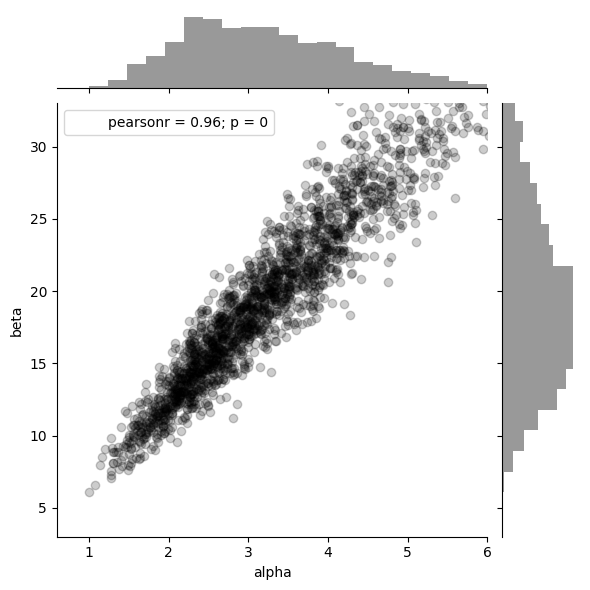

In [36]:
from pymc3.distributions.dist_math import bound

hierarchical = pm.Model()

with hierarchical:
    alpha = pm.Uniform('alpha', 0, 50)
    beta = pm.Uniform('beta', 0, 50)
    p = pm.Beta('p', alpha=alpha, beta=beta, shape=data.shape[0]) 
    # Shape is important because for each experiment we draw a new alpha beta
    tumors = pm.Binomial('tumors', n=data.rats,  p=p, observed=data.tumors) 
    trace = pm.sample(2000, tune=1000) 
    
    
df = pm.trace_to_dataframe(trace)
sns.jointplot(x='alpha', 
              y='beta', 
              data=df[['alpha', 'beta']],
              xlim=(.6, 6),
              ylim=(3, 33), 
              #kind='kde'
              color='k',
              alpha=.2
             ) 
#pm.traceplot(trace)
#pm.plots.autocorrplot(trace)

### Untransformed space with Gelman prior
* Now we turn to the prior proposed by Gellman et al.
* We first to the computation in in the untransformed space
* We need to implement the prior by hand. 
* Thiscan be done by pm.DensityDist, which allows to specify pdfs. 
* Spezifically, pmc3 requires the log-pdf to be specified using Theano (blow the function logprior) 
* Since the logprior is only defined on positive values for alpha and beta, we use ther the bound function from pymc3. 
* This function essentially sets all values to $-\infty$ for values outside the domain of definition. (we could alternatively implement this right away in the logprior function)
* Note that normalization in pm.DensityDist is irrelevant, as we are doing MCMC anyways (check this statement)

In [37]:
from pymc3.distributions.dist_math import bound
testval=[1.356, 8.615]
hierarchical = pm.Model()

def logprior(x):
    lprior =  - 5/2 * tt.log(x[0] + x[1])
    return bound(lprior, x[0] > 0, x[1] > 0) 
    return lprior

with hierarchical:
    prior = pm.DensityDist('prior', logprior, shape=2, testval=testval)
    tumors = pm.BetaBinomial('tumors', alpha=prior[0], beta=prior[1], n=data.rats, observed=data.tumors)
    trace_div = pm.sample(4000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 161.61:   3%|▎         | 6171/200000 [00:00<00:30, 6356.63it/s]
Convergence archived at 7000
Interrupted at 7,000 [3%]: Average Loss = 163.83
100%|█████████▉| 4985/5000 [00:08<00:00, 654.65it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 76 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5000/5000 [00:08<00:00, 584.05it/s]


#### Avoiding divergencies

* We observe that the MCMC run does not converge. This situations may occcur and are typically handled by reparametrizing the model. Of course we have a reparametrized model by hand: we could try to run the simulation on the transformed space. We will do this later, rather we will first try to find a reasonable reparametrization by some heuritic arguments. 


* Looking at the  prior distribution in the $\alpha - \beta$ space in the plots above it really seems a bit odd. It increases towards zero and then drops off to zero for non-positive values of  $\alpha, \beta$. Actually for negative values the pdf is not defined. But we can embedd the pdf over the whole $\mathbb R ^2$ by setting the pdf to zero for negative values.  At the end this is what also pymc3 does.


* So one obvious tranfo that avoids this jump near zero is the **log trafo**. Its a map $\mathbb R_{>0} \rightarrow \mathbb R$ It shifts the problem to $-\infty$. In pm.DensityDist allows (as for any pdf)  to speficy a tranfsformation. So let's do this with the log trafo.

In [38]:
with pm.Model() as model:
    prior = pm.DensityDist('prior', logprior, shape=2, testval=testval, transform=pm.distributions.transforms.Log())
    tumors = pm.BetaBinomial('tumors', alpha=prior[0], beta=prior[1], n=data.rats, observed=data.tumors)
    trace_log_trafo = pm.sample(4000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 168.51:   5%|▍         | 9106/200000 [00:01<00:21, 8823.63it/s]
Convergence archived at 9200
Interrupted at 9,200 [4%]: Average Loss = 176.53
100%|██████████| 5000/5000 [00:07<00:00, 657.80it/s]


* So this seems to work, cool. But now let's revisit our definition of the log prior:
* One we have chosen the log transformation, the original values are constrained to be positive. 
* The implementation of the bound method seems to be obsolete. Putting things together we can also set up the model as 

In [39]:
def logprior_2(x):
    return  - 5/2 * tt.log(x[0] + x[1])

with pm.Model() as model:
    prior = pm.DensityDist('prior', logprior_2, shape=2, testval=testval, transform=pm.distributions.transforms.Log())
    tumors = pm.BetaBinomial('tumors', alpha=prior[0], beta=prior[1], n=data.rats, observed=data.tumors)
    trace_log_trafo_no_bound = pm.sample(4000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 168.56:   4%|▍         | 8947/200000 [00:01<00:21, 8856.18it/s]
Convergence archived at 9200
Interrupted at 9,200 [4%]: Average Loss = 176.53
100%|██████████| 5000/5000 [00:07<00:00, 711.66it/s]


* Let's quickly have a look at if the sampled space is the same.
* This is just a first quick look. 
* Later we shall see how the various parametrizations impact the prediction - at the end that's what we are interested

In [40]:
df_div = pm.trace_to_dataframe(trace_div)
df_log_trafo = pm.trace_to_dataframe(trace_log_trafo)
df_log_trafo_no_bound = pm.trace_to_dataframe(trace_log_trafo_no_bound)

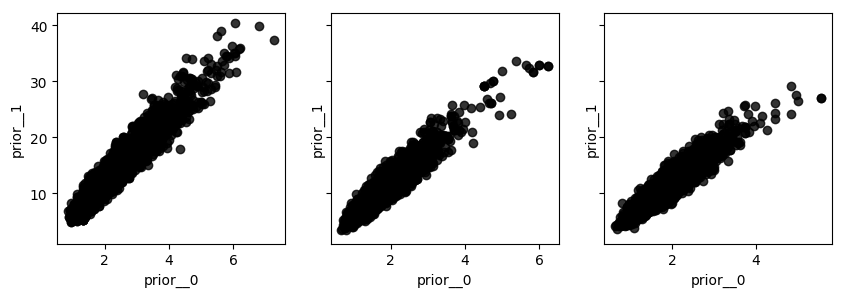

In [41]:
def plot_marginal_posterior(df: DataFrame, ax):
    return sns.regplot(x='prior__0', 
                  y='prior__1', 
                  data=df[['prior__0', 'prior__1']],
                  #xlim=(.6, 6),
                  #ylim=(3, 33), 
                  fit_reg=False,
                  color='k', ax=ax)

fig, axes = plt.subplots(1,3,sharey=True, figsize=(10,3))    
plot_marginal_posterior(df_div, axes[0])
plot_marginal_posterior(df_log_trafo, axes[1])
plot_marginal_posterior(df_log_trafo_no_bound, axes[2])

* So far we have reparametrized our model based on transformations that obeyed the requirement
* Find any transformation that maps from the domain of definition to the entire real line. 
* In our case this was the log trafo. But we can also work in the transformed space from above. Let's do this for completeness.
### Transformed space

In [42]:
hierarchical_with_trafo = pm.Model()


def logpdf_transformed(x):
    return -1/2*x[1] - tt.log(2 + tt.exp(-x[0]) + tt.exp(x[0]))


def pullback(x_prime):
    alpha = tt.exp(x_prime[1]) / (1+  tt.exp(-x_prime[0]))
    beta = tt.exp(x_prime[1]) - alpha
    return alpha, beta

    
with hierarchical_with_trafo:
    ab_prime = pm.DensityDist('prior_prime', logpdf_transformed, shape=2)
    alpha, beta = pullback(ab_prime)
    tumors = pm.BetaBinomial('tumors', alpha=alpha, beta=beta, n=data.rats, observed=data.tumors)
    trace_trafo = pm.sample(2000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 162.11:   5%|▌         | 10959/200000 [00:01<00:19, 9585.34it/s]
Convergence archived at 11000
Interrupted at 11,000 [5%]: Average Loss = 186.65
100%|██████████| 3000/3000 [00:02<00:00, 1132.92it/s]


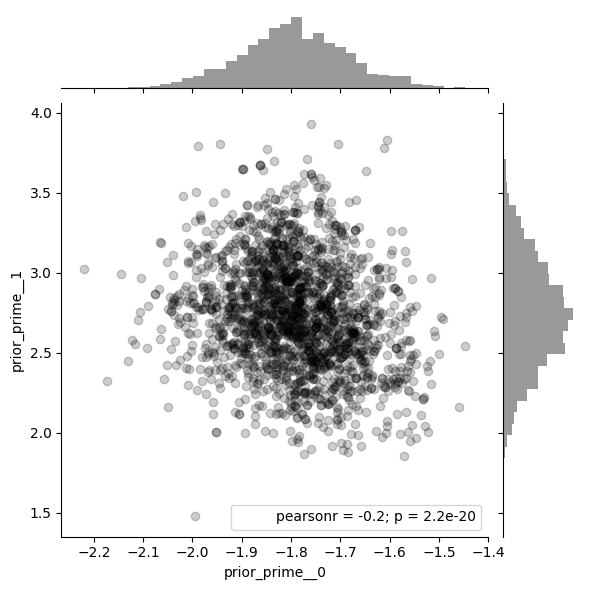

In [43]:
df_trafo = pm.trace_to_dataframe(trace_trafo)
sns.jointplot(x='prior_prime__0', 
              y='prior_prime__1', 
              data=df_trafo[['prior_prime__0', 'prior_prime__1']],
              #xlim=(.6, 6),
              #ylim=(3, 33), 
              color='k',
              alpha=.2
             )

In [44]:
df_trafo.columns

Index(['prior_prime__0', 'prior_prime__1'], dtype='object')

* This is the result in the primed space in order to make contact with the unprimed space we need to backtransform this result:

In [45]:
alphas = np.exp(df_trafo['prior_prime__1']) / (1+  np.exp(-df_trafo['prior_prime__0']))
betas = np.exp(df_trafo['prior_prime__1']) - alphas
backtransfomed = pd.DataFrame({'alpha': alphas, 'beta': betas})

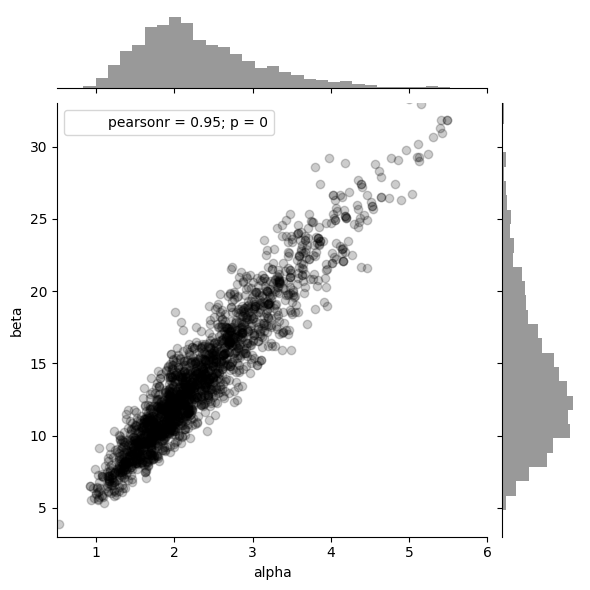

In [46]:
sns.jointplot(x='alpha', 
              y='beta', 
              data=backtransfomed,
              xlim=(.5, 6),
              ylim=(3, 33), 
              color='k',
              alpha=.2
             )

# Making predictions 
* Now we want to make a prediction. That is, for a new experiment with N rats and T of those having Tumors we would like to compute the tumor rate.
So we need to calculate $\int p(\theta | \alpha, \beta, N, T) p(\alpha, \beta) ~ d\alpha ~ d\beta$

In [49]:
RATS = 14
TUMORS = 4
grid = np.linspace(0, 1, 5000) 
pymc_div = sample_theta_posterior( df_div.rename(columns={'prior__0': 'alpha', 'prior__1': 'beta'}),
                                                TUMORS, RATS, grid)

pymc_log_no_bound = sample_theta_posterior( df_log_trafo_no_bound.rename(columns={'prior__0': 'alpha', 'prior__1': 'beta'}),
                                                TUMORS, RATS, grid)
pymc_log_trafo = sample_theta_posterior(df_log_trafo.rename(columns={'prior__0': 'alpha', 'prior__1': 'beta'}),
                                                TUMORS, RATS, grid)
pymc_transformed = sample_theta_posterior(backtransfomed, TUMORS, RATS, grid)
analytical_prediction = sample_theta_posterior(samples, TUMORS, RATS, grid)

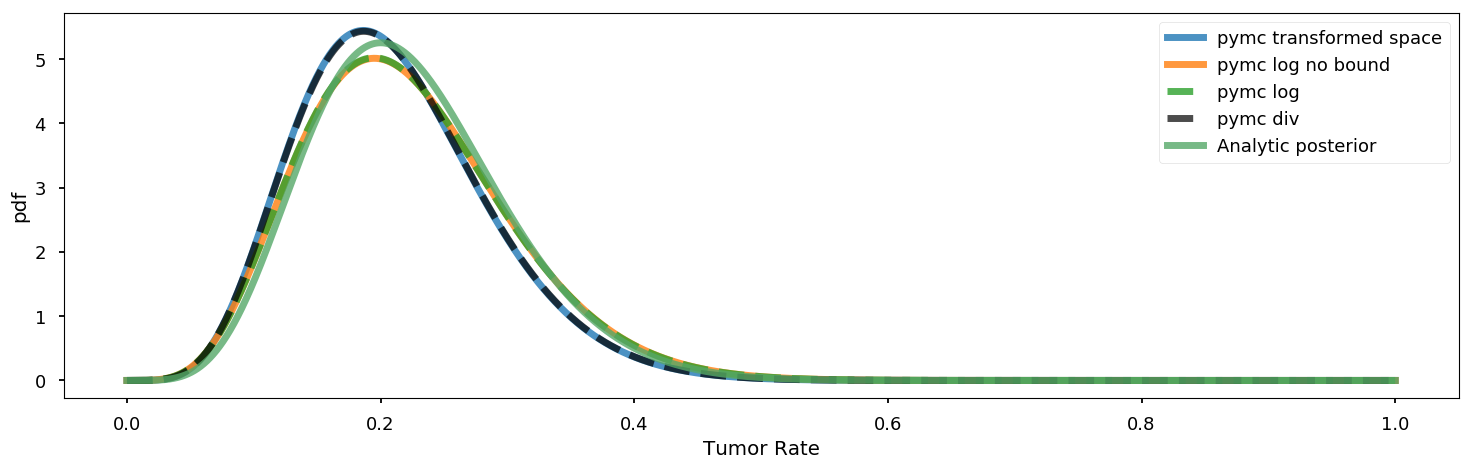

In [50]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(grid, pymc_transformed, '-', alpha = 0.8, linewidth=5, label='pymc transformed space')
ax.plot(grid, pymc_log_no_bound, '-', alpha = 0.8, linewidth=5, label='pymc log no bound')
ax.plot(grid, pymc_log_trafo, '--', alpha = 0.8, linewidth=5, label='pymc log ')
ax.plot(grid, pymc_div, '--k', alpha = 0.7, linewidth=5, label='pymc div')
ax.plot(grid, analytical_prediction, '-', alpha = 0.8, color='#55a868', linewidth=5, label='Analytic posterior')
#sns.distplot([n.mean() for n in ppc['tumors'] / RATS] , kde=False, norm_hist=True, ax=ax)
ax.set_xlabel('Tumor Rate')
ax.set_ylabel('pdf')
plt.legend();